In [1]:
import scipy.optimize
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pandas.read_csv('Step1.csv')
ydata = df.T1.values
udata = df.Q1.values
time = df.Time.values

ydev = ydata - ydata[0]
udev = ydata - udata[0]

In [42]:
def ARX(A, B, Y, U):
#     print("A", [len(i) for i in [A, B, Y, U]])
    return A.dot(Y) + B.dot(U)

In [21]:
# The objective function for doublet

def OF_gen(m, n, ydev, udev):
    def OF(x):
        A, B = x[:m], x[m:]
#         print("B", x, x[:m], x[m+1:])

        ydev_app = np.concatenate([ydev, [0]*m])
        udev_app = np.concatenate([udev, [0]*n]) 

        summ = 0
        for j in range(len(ydev)):
            k = j + m
            l = j + n

            Y = np.flip(ydev_app[j:k])
            U = np.flip(udev_app[j:l])
            yt = ARX(A, B, Y, U)
            summ += (ydev[j] - yt)**2

        return summ
    return OF

In [50]:
def simulate(A, B, Uinput):
#     Y = [0]*len(A)
    Youtput = []
    for i in range(len(Uinput)):
        if i < len(B):
            U = [0]*(len(B) - i) + list(Uinput[:i])
        else:
            j = i - len(B)
            U = list(Uinput[j:i])
        U.reverse()
#         yt = ARX(A, B, Y, U)
#         Y.pop()
#         Y = [yt] + Y
        
        if i < len(A):
            Y = [0]*(len(A) - len(Youtput)) + Youtput
        else:
            Y = Youtput[-len(A):]
        Y.reverse()

        yt = ARX(A, B, Y, U)
        Youtput.append(yt)
    return Youtput

## I'm identifying the parameters of an ARX model using differential evolution.

In [40]:
m = 2
n = 2
OF = OF_gen(m, n, ydev, udev)

In [29]:
# Comparison with minimize.

Xo = [0.9799079, 0.01606574, 0.001687, 0.00264688]
par_min = scipy.optimize.minimize(OF, Xo)
par_min

      fun: 9.358158185686272e-10
 hess_inv: array([[ 0.14483635, -0.14435039, -0.08573226,  0.08543442],
       [-0.14435039,  0.14389416,  0.0854473 , -0.08516588],
       [-0.08573226,  0.0854473 ,  0.05093858, -0.05076361],
       [ 0.08543442, -0.08516588, -0.05076361,  0.05059797]])
      jac: array([ 4.03370129e-10,  1.69812067e-10, -2.59172515e-09, -2.05896959e-09])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([ 3.98536678e-06,  9.99996235e-01, -2.34232707e-06,  2.21276569e-06])

In [51]:
A, B = par_min.x[:m], par_min.x[m:]
Yout = simulate(A, B, udev)

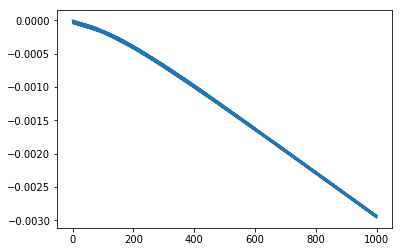

In [52]:
plt.plot(time, Yout)
plt.show()

In [24]:
# Differential Evolution.

bnds = ((-1,1), (-1,1), (-1,1), (-1,1))#, (-1,1), (-1,1))
par_DE = scipy.optimize.differential_evolution(OF, bounds=bnds)
par_DE

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35205
     nit: 584
 success: True
       x: array([0., 1., 0., 0.])

### Not sure why this optimization isn't successful, yet the same values for a1, a2, b1 and b2 are determined as in differential evolution.

## Calculating Predictions

In [6]:
# Step response
a1, a2, b1, b2 = par_DE.x

ydev = ydata - ydata[0]
udev = udata - udata[0]

    
y_difev = []
us = []
y_0 = y_1 = y_2 = ydev[0]
for i, ti in enumerate(time):
    u_1 = 0 if i < 1 else udev[i-1]
    u_2 = 0 if i < 2 else udev[i-2]
    y_2, y_1 = y_1, y_0
    y_0 = a1*y_1 + a2*y_2 + b1*u_1 + b2*u_2
    us.append([u_1, u_2])
    y_difev.append(y_0)

y_difev = np.array(y_difev + ydata[0]) 


In [7]:
plt.plot(time, ydata)
plt.plot(time, y_difev)

### Now for other data:

In [8]:
rpi = pandas.read_csv('Rpi1_Q1_only.csv')
yrpi = rpi.T1.values
urpi = rpi.Q1.values
t_rpi = rpi.Time.values

doublet = pandas.read_csv('Doublet1_Q1_only.csv')
y_doublet = doublet.T1.values
u_doublet = doublet.Q1.values
t_doublet = doublet.Time.values

In [9]:
# The objective function for RPI

def OF_rpi(x):
    a1, a2, b1, b2 = x
    ydev = yrpi - yrpi[0]
    udev = urpi - urpi[0]
    yt = []
    for i, it in enumerate(time):
        if i-1<0:
            y1 = ydev[0]
            u1 = udev[0]
        else:
            y1 = ydev[i-1]
            u1 = udev[i-1]
        if i-2<0:
            y2 = ydev[0]
            u2 = udev[0]
        else:
            y2 = ydev[i-2]
            u2 = udev[i-2]
        if i-3<0:
            y3 = ydev[0]
            u3 = udev[0]
        else:
            y3 = ydev[i-3]
            u3 = udev[i-3]
        yt.append(a1*y1 + a2*y2 + b1*u1 + b2*u2 )#+ a3*y3 + b3*u3)
    
    return sum((yrpi - (yt+yrpi[0]))**2)

In [10]:
# Differential Evolution RPI.

bnds = ((-1,1), (-1,1), (-1,1), (-1,1))#, (-1,1), (-1,1))
par_rpi = scipy.optimize.differential_evolution(OF_rpi, bounds=bnds)
par_rpi

     fun: 15.963949602543154
     jac: array([-0.00121929, -0.00109246, -0.00340421, -0.00234586])
 message: 'Optimization terminated successfully.'
    nfev: 4160
     nit: 66
 success: True
       x: array([4.82263695e-01, 5.09284201e-01, 2.96500825e-04, 4.97146085e-03])

In [11]:
# RPI
a1, a2, b1, b2 = par_rpi.x

ydev = yrpi - yrpi[0]
udev = urpi - urpi[0]

    
y_difev_rpi= []
us = []
y_0 = y_1 = y_2 = ydev[0]
for i, ti in enumerate(time):
    u_1 = 0 if i < 1 else udev[i-1]
    u_2 = 0 if i < 2 else udev[i-2]
    y_2, y_1 = y_1, y_0
    y_0 = a1*y_1 + a2*y_2 + b1*u_1 + b2*u_2
    us.append([u_1, u_2])
    y_difev_rpi.append(y_0)

y_difev_rpi = np.array(y_difev_rpi + yrpi[0]) 


In [12]:
plt.plot(time, yrpi)
plt.plot(time, y_difev_rpi)

In [14]:
# Differential Evolution Doublet.

bnds = ((-1,1), (-1,1), (-1,1), (-1,1))#, (-1,1), (-1,1))
par_doublet = scipy.optimize.differential_evolution(OF_doublet, bounds=bnds)
par_doublet

     fun: 16.876595076354054
     jac: array([ 0.02270255,  0.02252172, -0.0179984 , -0.01574598])
 message: 'Optimization terminated successfully.'
    nfev: 3275
     nit: 51
 success: True
       x: array([ 0.69801782,  0.30296859, -0.00686488,  0.01344923])

In [15]:
# Doublet
a1, a2, b1, b2 = par_doublet.x

ydev = y_doublet - y_doublet[0]
udev = u_doublet - u_doublet[0]

    
y_difev_doub= []
us = []
y_0 = y_1 = y_2 = ydev[0]
for i, ti in enumerate(time):
    u_1 = 0 if i < 1 else udev[i-1]
    u_2 = 0 if i < 2 else udev[i-2]
    y_2, y_1 = y_1, y_0
    y_0 = a1*y_1 + a2*y_2 + b1*u_1 + b2*u_2
    us.append([u_1, u_2])
    y_difev_doub.append(y_0)

y_difev_doub = np.array(y_difev_doub + y_doublet[0]) 

In [16]:
plt.plot(time, y_doublet)
plt.plot(time, y_difev_doub)